In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [346]:
from scipy.stats import skew, boxcox, expon, reciprocal, uniform
from scipy.cluster.hierarchy import linkage, dendrogram

In [306]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.model_selection import cross_val_score, GridSearchCV, train_test_split, RandomizedSearchCV
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestRegressor
from sklearn.cross_decomposition import PLSRegression
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.decomposition import PCA
from sklearn.metrics import r2_score, mean_squared_error

from sklearn_pandas import DataFrameMapper, gen_features

In [4]:
class BoxcoxTransformer(BaseEstimator, TransformerMixin):
    '''perform box-cox transformation'''
    
    def fit(self, X, y=None):
        x_min = X.min()
        if x_min == 0:
            self.shift_ = 1.0
        elif x_min < 0:
            self.shift_ = abs(x_min) + 1
        else:
            self.shift_ = 0.0
        _, self.lam_ = boxcox(X + self.shift_)
        return self
    
    def transform(self, X):
        return boxcox(X + self.shift_, lmbda=self.lam_)

In [415]:
def plot_explain(y_true, y_pred, title=''):
    fig, ax = plt.subplots(ncols=2, figsize=(10, 5))
    res = y_true - y_pred
    ax[0].scatter(y_pred, y_true, alpha=.4)
    ax[0].plot(ax[0].get_xlim(), ax[0].get_ylim(), linestyle='--', color='k')
    ax[0].set(xlabel='predict', ylabel='true')
    
    ax[1].scatter(y_pred, res, alpha=.4)
    ax[1].axhline(0, linestyle='--', color='k')
    ax[1].set(xlabel='predict', ylabel='residuals')
    
    fig.suptitle("{}:\n[R2: {:.3f}, RMSE: {:.3f}]".format(title.upper(), 
                                                       r2_score(y_true, y_pred), 
                                                       np.sqrt(mean_squared_error(y_true, y_pred))))
    

In [5]:
X_train = pd.read_csv('datasets/solubility/solTrainX.csv', index_col=0)
y_train = pd.read_csv('datasets/solubility/solTrainY.csv', index_col=0).iloc[:, 0]

In [6]:
X_test = pd.read_csv('datasets/solubility/solTestX.csv', index_col=0)
y_test = pd.read_csv('datasets/solubility/solTestY.csv', index_col=0).iloc[:, 0]
X_test.shape, y_test.shape

((316, 228), (316,))

In [7]:
X_train.shape, y_train.shape

((951, 228), (951,))

In [8]:
X_train.head()

FP001  FP002  FP003  FP004  FP005  FP006  FP007  FP008  FP009  FP010  \
661      0      1      0      0      1      0      0      1      0      0   
662      0      1      0      1      1      1      1      1      0      0   
663      1      1      1      1      1      0      0      1      0      1   
665      0      0      1      0      0      0      1      0      0      0   
668      0      0      1      1      1      1      0      0      1      0   

         ...       NumCarbon  NumNitrogen  NumOxygen  NumSulfer  NumChlorine  \
661      ...              14            2          0          0            0   
662      ...              21            3          1          1            0   
663      ...              13            0          2          0            0   
665      ...              10            0          0          0            0   
668      ...               9            5          0          0            1   

     NumHalogen  NumRings  HydrophilicFactor  SurfaceArea1  SurfaceArea2  
661           0         3             -0.856         25.78         25.78  
662           0         4             -0.370         52.19         80.43  
663           0         1             -0.330         37.30         37.30  
665           0         1             -0.960          0.00          0.00  
668           1         1             -0.069         53.94         53.94  

[5 rows x 228 columns]

In [9]:
mask_int = (X_train.dtypes == int)
mask_float = (X_train.dtypes == float)
mask_bin = (X_train.nunique() == 2)

In [10]:
bin_cols = list(X_train.columns[mask_bin])

count_cols = list(X_train.columns[(~mask_bin & mask_int)])

num_cols = list(X_train.columns[(~mask_bin & mask_float)])

In [11]:
len(bin_cols), len(count_cols), len(num_cols)

(208, 16, 4)

In [12]:
y_train.describe()

count    951.000000
mean      -2.718570
std        2.046641
min      -11.620000
25%       -3.955000
50%       -2.510000
75%       -1.360000
max        1.580000
Name: 0, dtype: float64

In [15]:
count_skew = X_train[count_cols].apply(skew)
count_skew.mean(), count_skew.std()

(1.5843461919994652, 0.8970172546163206)

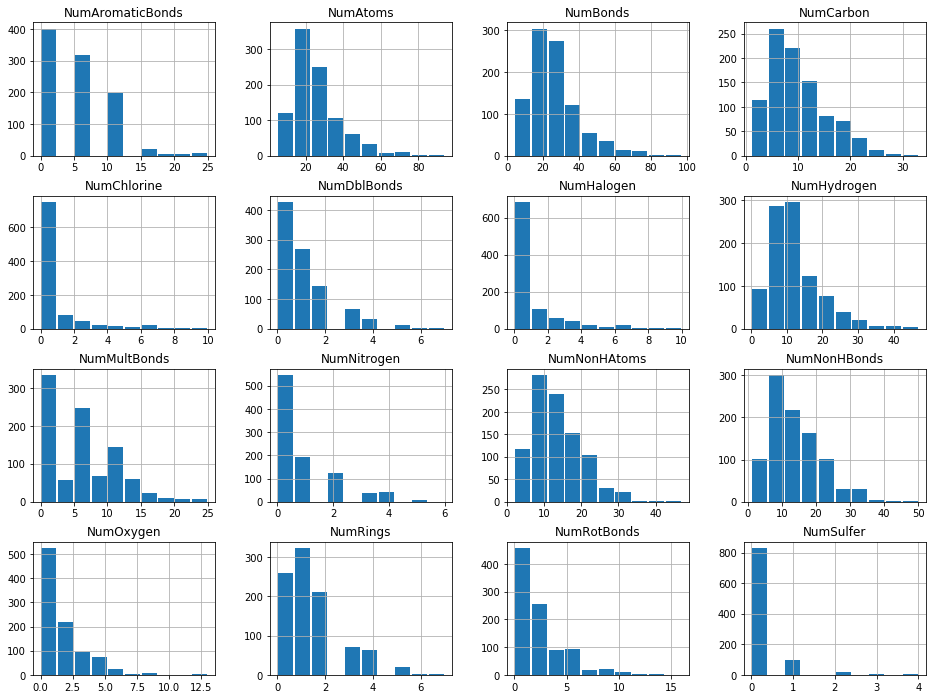

In [45]:
_ = X_train[count_cols].hist(rwidth=.9, figsize=(16, 12))

In [47]:
X_train[count_cols].describe().T

count       mean        std  min   25%   50%   75%   max
NumAtoms          951.0  25.506835  12.614015  5.0  17.0  22.0  31.0  94.0
NumNonHAtoms      951.0  13.160883   6.497156  2.0   8.0  12.0  17.0  47.0
NumBonds          951.0  25.908517  13.476882  4.0  17.0  23.0  31.5  97.0
NumNonHBonds      951.0  13.562566   7.566966  1.0   8.0  12.0  18.0  50.0
NumMultBonds      951.0   6.148265   5.171795  0.0   1.0   6.0  10.0  25.0
NumRotBonds       951.0   2.251314   2.408523  0.0   0.0   2.0   3.5  16.0
NumDblBonds       951.0   1.006309   1.210464  0.0   0.0   1.0   2.0   7.0
NumAromaticBonds  951.0   5.120925   5.260087  0.0   0.0   6.0   6.0  25.0
NumHydrogen       951.0  12.345952   7.318699  0.0   7.0  11.0  16.0  47.0
NumCarbon         951.0   9.892744   5.293597  1.0   6.0   9.0  12.0  33.0
NumNitrogen       951.0   0.812829   1.186185  0.0   0.0   0.0   1.0   6.0
NumOxygen         951.0   1.574132   1.729169  0.0   0.0   1.0   2.0  13.0
NumSulfer         951.0   0.164038   0.488187  0.0   0.0   0.0   0.0   4.0
NumChlorine       951.0   0.556257   1.400278  0.0   0.0   0.0   0.0  10.0
NumHalogen        951.0   0.698212   1.472694  0.0   0.0   0.0   1.0  10.0
NumRings          951.0   1.401682   1.298808  0.0   0.0   1.0   2.0   7.0

In [16]:
X_train[num_cols].apply(skew)

MolWeight            0.988383
HydrophilicFactor    3.403785
SurfaceArea1         1.714144
SurfaceArea2         1.475042
dtype: float64

In [51]:
X_train[num_cols].describe().T

count        mean        std     min      25%      50%  \
MolWeight          951.0  201.653575  97.907971  46.090  122.605  179.230   
HydrophilicFactor  951.0   -0.020592   1.126010  -0.985   -0.763   -0.314   
SurfaceArea1       951.0   36.458938  35.288510   0.000    9.230   29.100   
SurfaceArea2       951.0   40.234185  38.123765   0.000   10.630   33.120   

                       75%      max  
MolWeight          264.340  665.810  
HydrophilicFactor    0.313   13.483  
SurfaceArea1        53.280  331.940  
SurfaceArea2        60.660  331.940

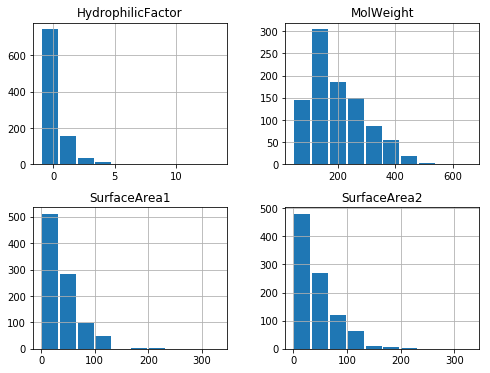

In [50]:
_ = X_train[num_cols].hist(rwidth=.9, figsize=(8, 6))

### 10-fold cross-validation 

In [17]:
n_split = 10
k10 = KFold(n_splits=n_split, shuffle=True, random_state=123)

### Baseline: RandomForestRegressor()

In [18]:
scores = cross_val_score(RandomForestRegressor(), X_train, y_train, cv=k10, scoring='r2')
scores.mean(), scores.std()

(0.88364725764513241, 0.022503182244341821)

In [19]:
scores = cross_val_score(RandomForestRegressor(), X_train, y_train, cv=k10, scoring='neg_mean_squared_error')
rmse = np.sqrt(-scores)
rmse.mean(), rmse.std()

(0.70204637401365955, 0.064192074981766351)

In [20]:
rf = RandomForestRegressor().fit(X_train, y_train)

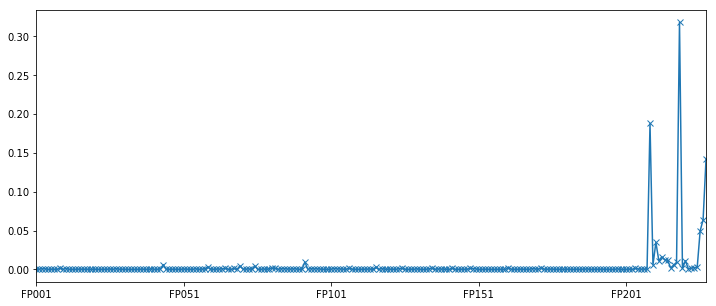

In [21]:
pd.Series(rf.feature_importances_, index=X_train.columns).plot(figsize=(12, 5), style='-x')

Text(0.5,1,'residual plot')

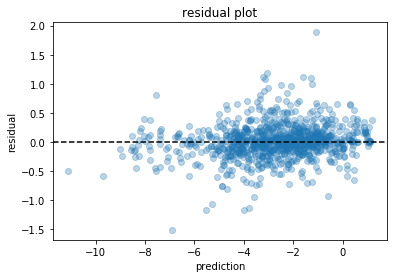

In [22]:
y_pred = rf.predict(X_train)

residual = y_train - y_pred

plt.plot(y_pred, residual, 'o', alpha=.3)
plt.axhline(y=0, linestyle='--', color='k')
plt.ylabel('residual')
plt.xlabel('prediction')
plt.title('residual plot')

In [83]:
skewness = X_train[num_cols + count_cols].apply(skew)
skewness

MolWeight            0.988383
HydrophilicFactor    3.403785
SurfaceArea1         1.714144
SurfaceArea2         1.475042
NumAtoms             1.364463
NumNonHAtoms         0.993077
NumBonds             1.360045
NumNonHBonds         0.969303
NumMultBonds         0.670239
NumRotBonds          1.577461
NumDblBonds          1.359624
NumAromaticBonds     0.795632
NumHydrogen          1.261543
NumCarbon            0.927339
NumNitrogen          1.554093
NumOxygen            1.771690
NumSulfer            3.841531
NumChlorine          3.177938
NumHalogen           2.691486
NumRings             1.034075
dtype: float64

In [84]:
skewness.describe()

count    20.000000
mean      1.646545
std       0.908630
min       0.670239
25%       0.991904
50%       1.362254
75%       1.728530
max       3.841531
dtype: float64

In [85]:
X_train[num_cols+ count_cols].min()

MolWeight            46.090
HydrophilicFactor    -0.985
SurfaceArea1          0.000
SurfaceArea2          0.000
NumAtoms              5.000
NumNonHAtoms          2.000
NumBonds              4.000
NumNonHBonds          1.000
NumMultBonds          0.000
NumRotBonds           0.000
NumDblBonds           0.000
NumAromaticBonds      0.000
NumHydrogen           0.000
NumCarbon             1.000
NumNitrogen           0.000
NumOxygen             0.000
NumSulfer             0.000
NumChlorine           0.000
NumHalogen            0.000
NumRings              0.000
dtype: float64

In [110]:
data = X_train[count_cols + num_cols].copy()
data['target'] = y_train

In [111]:
data.head()

NumAtoms  NumNonHAtoms  NumBonds  NumNonHBonds  NumMultBonds  \
661        28            16        30            18            16   
662        49            26        52            29            13   
663        33            15        33            15             7   
665        26            10        26            10             2   
668        31            15        31            15             6   

     NumRotBonds  NumDblBonds  NumAromaticBonds  NumHydrogen  NumCarbon  \
661            0            0                16           12         14   
662            4            0                12           23         21   
663            4            1                 6           18         13   
665            1            2                 0           16         10   
668            5            0                 6           16          9   

      ...    NumOxygen  NumSulfer  NumChlorine  NumHalogen  NumRings  \
661   ...            0          0            0           0         3   
662   ...            1          1            0           0         4   
663   ...            2          0            0           0         1   
665   ...            0          0            0           0         1   
668   ...            0          0            1           1         1   

     MolWeight  HydrophilicFactor  SurfaceArea1  SurfaceArea2  target  
661     208.28             -0.856         25.78         25.78   -1.84  
662     365.54             -0.370         52.19         80.43   -1.85  
663     206.31             -0.330         37.30         37.30   -1.85  
665     136.26             -0.960          0.00          0.00   -1.85  
668     229.75             -0.069         53.94         53.94   -1.89  

[5 rows x 21 columns]

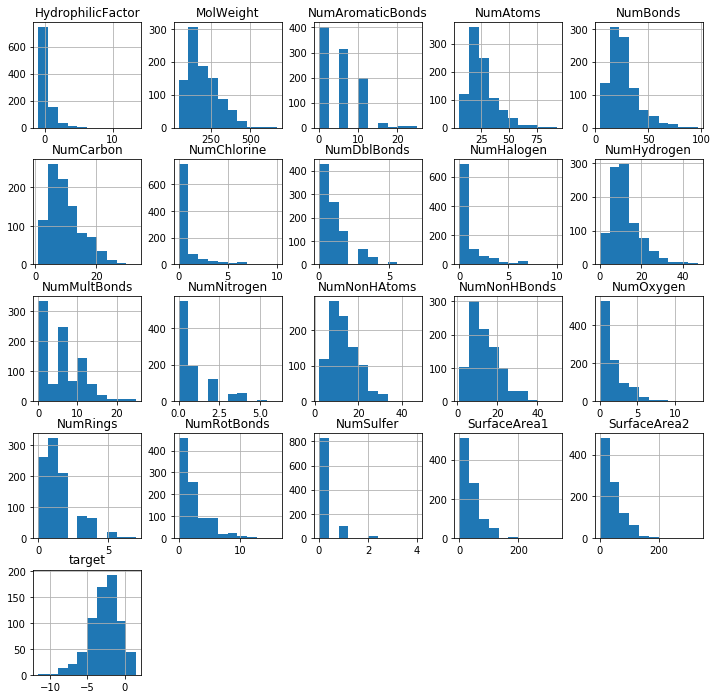

In [120]:
_ = data.hist(figsize=(12, 12))

In [23]:
bx_transform = DataFrameMapper(gen_features(num_cols+count_cols, classes=[BoxcoxTransformer]), default=None, 
                               df_out=True, input_df=True)

In [25]:
data_bx = bx_transform.fit_transform(X_train)

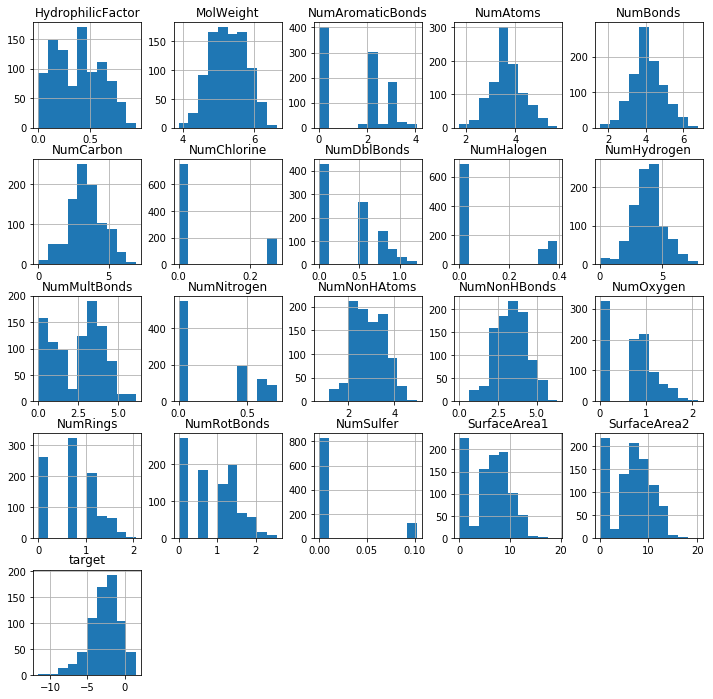

In [124]:
_ = data_bx.hist(figsize=(12, 12))

/home/pongsakorn/anaconda3/envs/py35/lib/python3.5/site-packages/numpy/lib/function_base.py:4016: RuntimeWarning: Invalid value encountered in median
  r = func(a, **kwargs)
/home/pongsakorn/anaconda3/envs/py35/lib/python3.5/site-packages/statsmodels/nonparametric/smoothers_lowess.py:165: RuntimeWarning: invalid value encountered in greater_equal
  res = _lowess(y, x, frac=frac, it=it, delta=delta)
/home/pongsakorn/anaconda3/envs/py35/lib/python3.5/site-packages/statsmodels/nonparametric/smoothers_lowess.py:165: RuntimeWarning: invalid value encountered in true_divide
  res = _lowess(y, x, frac=frac, it=it, delta=delta)


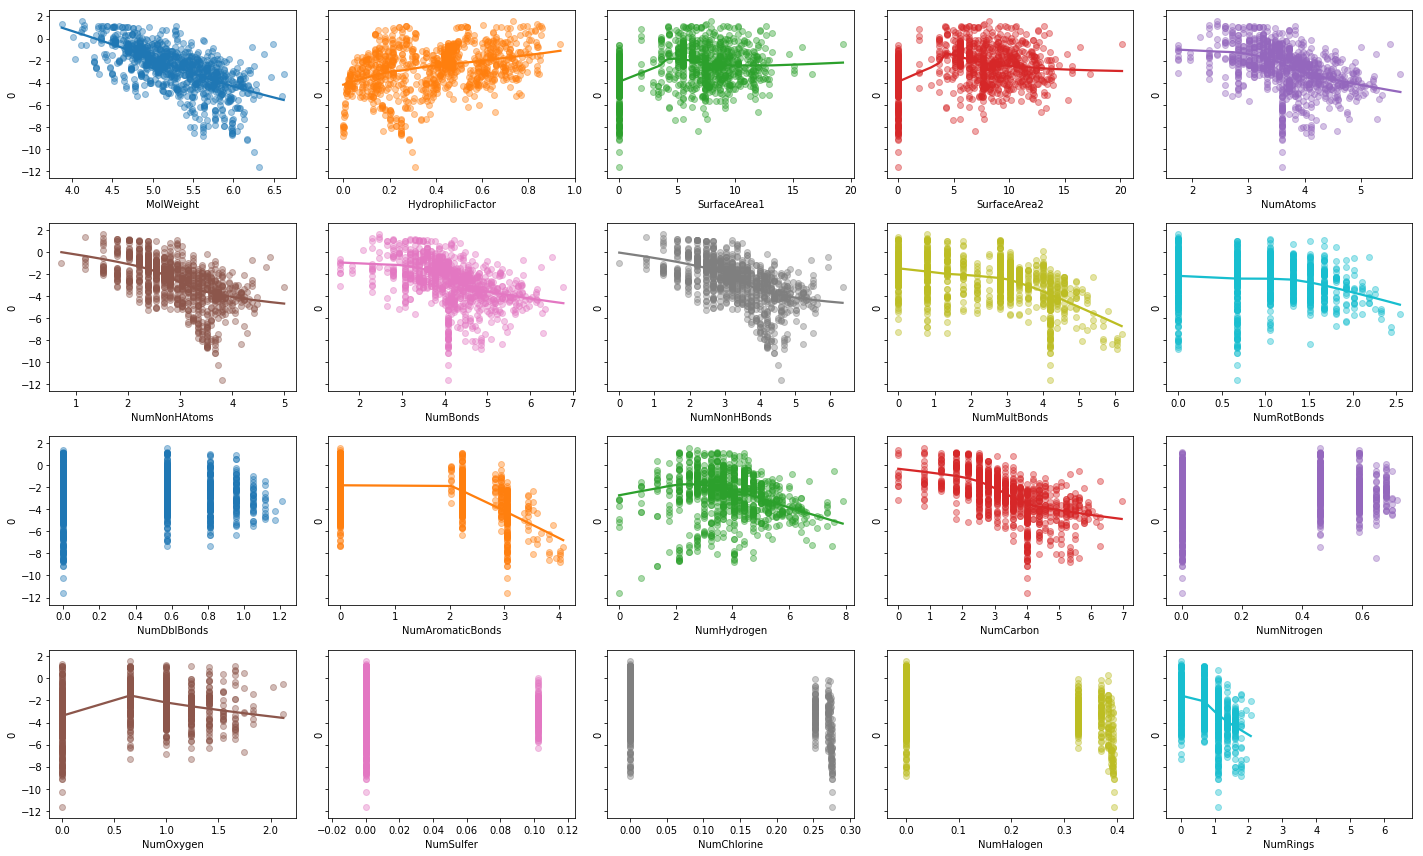

In [138]:
fig, ax = plt.subplots(ncols=5, nrows=4, figsize=(20, 12), sharey=True)
for axi, c in zip(ax.flat, num_cols+count_cols):
    sns.regplot(data_bx[c], y_train, ax=axi, scatter_kws={"alpha":.4}, lowess=True)

fig.tight_layout()

In [26]:
pca = PCA()
data_bx_pca = pca.fit_transform(data_bx)

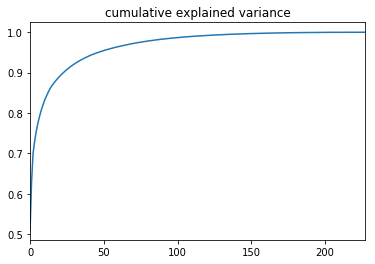

In [27]:
pd.Series(pca.explained_variance_ratio_).cumsum().plot(title ='cumulative explained variance')

In [163]:
(pca.explained_variance_ratio_.cumsum() < .95).sum()

47

In [249]:
corr = data_bx[num_cols+count_cols].corr()

Y = linkage(corr, method='complete', metric='correlation')
Z = dendrogram(Y, no_plot=True)['leaves']
corr = corr.iloc[:, Z]
corr = corr.iloc[Z, :]

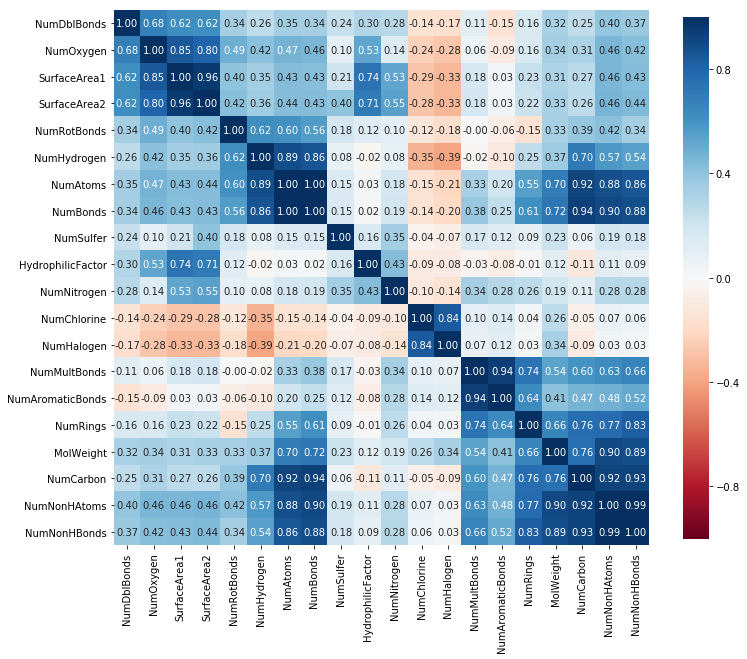

In [175]:
fig, ax = plt.subplots(figsize=(12, 12))
sns.heatmap(corr, square=True, annot=True, fmt='.2f', ax=ax, 
            vmin=-1, vmax=1, cmap=plt.cm.RdBu, cbar_kws={"shrink":.8})

In [174]:
from scipy.spatial.distance import pdist

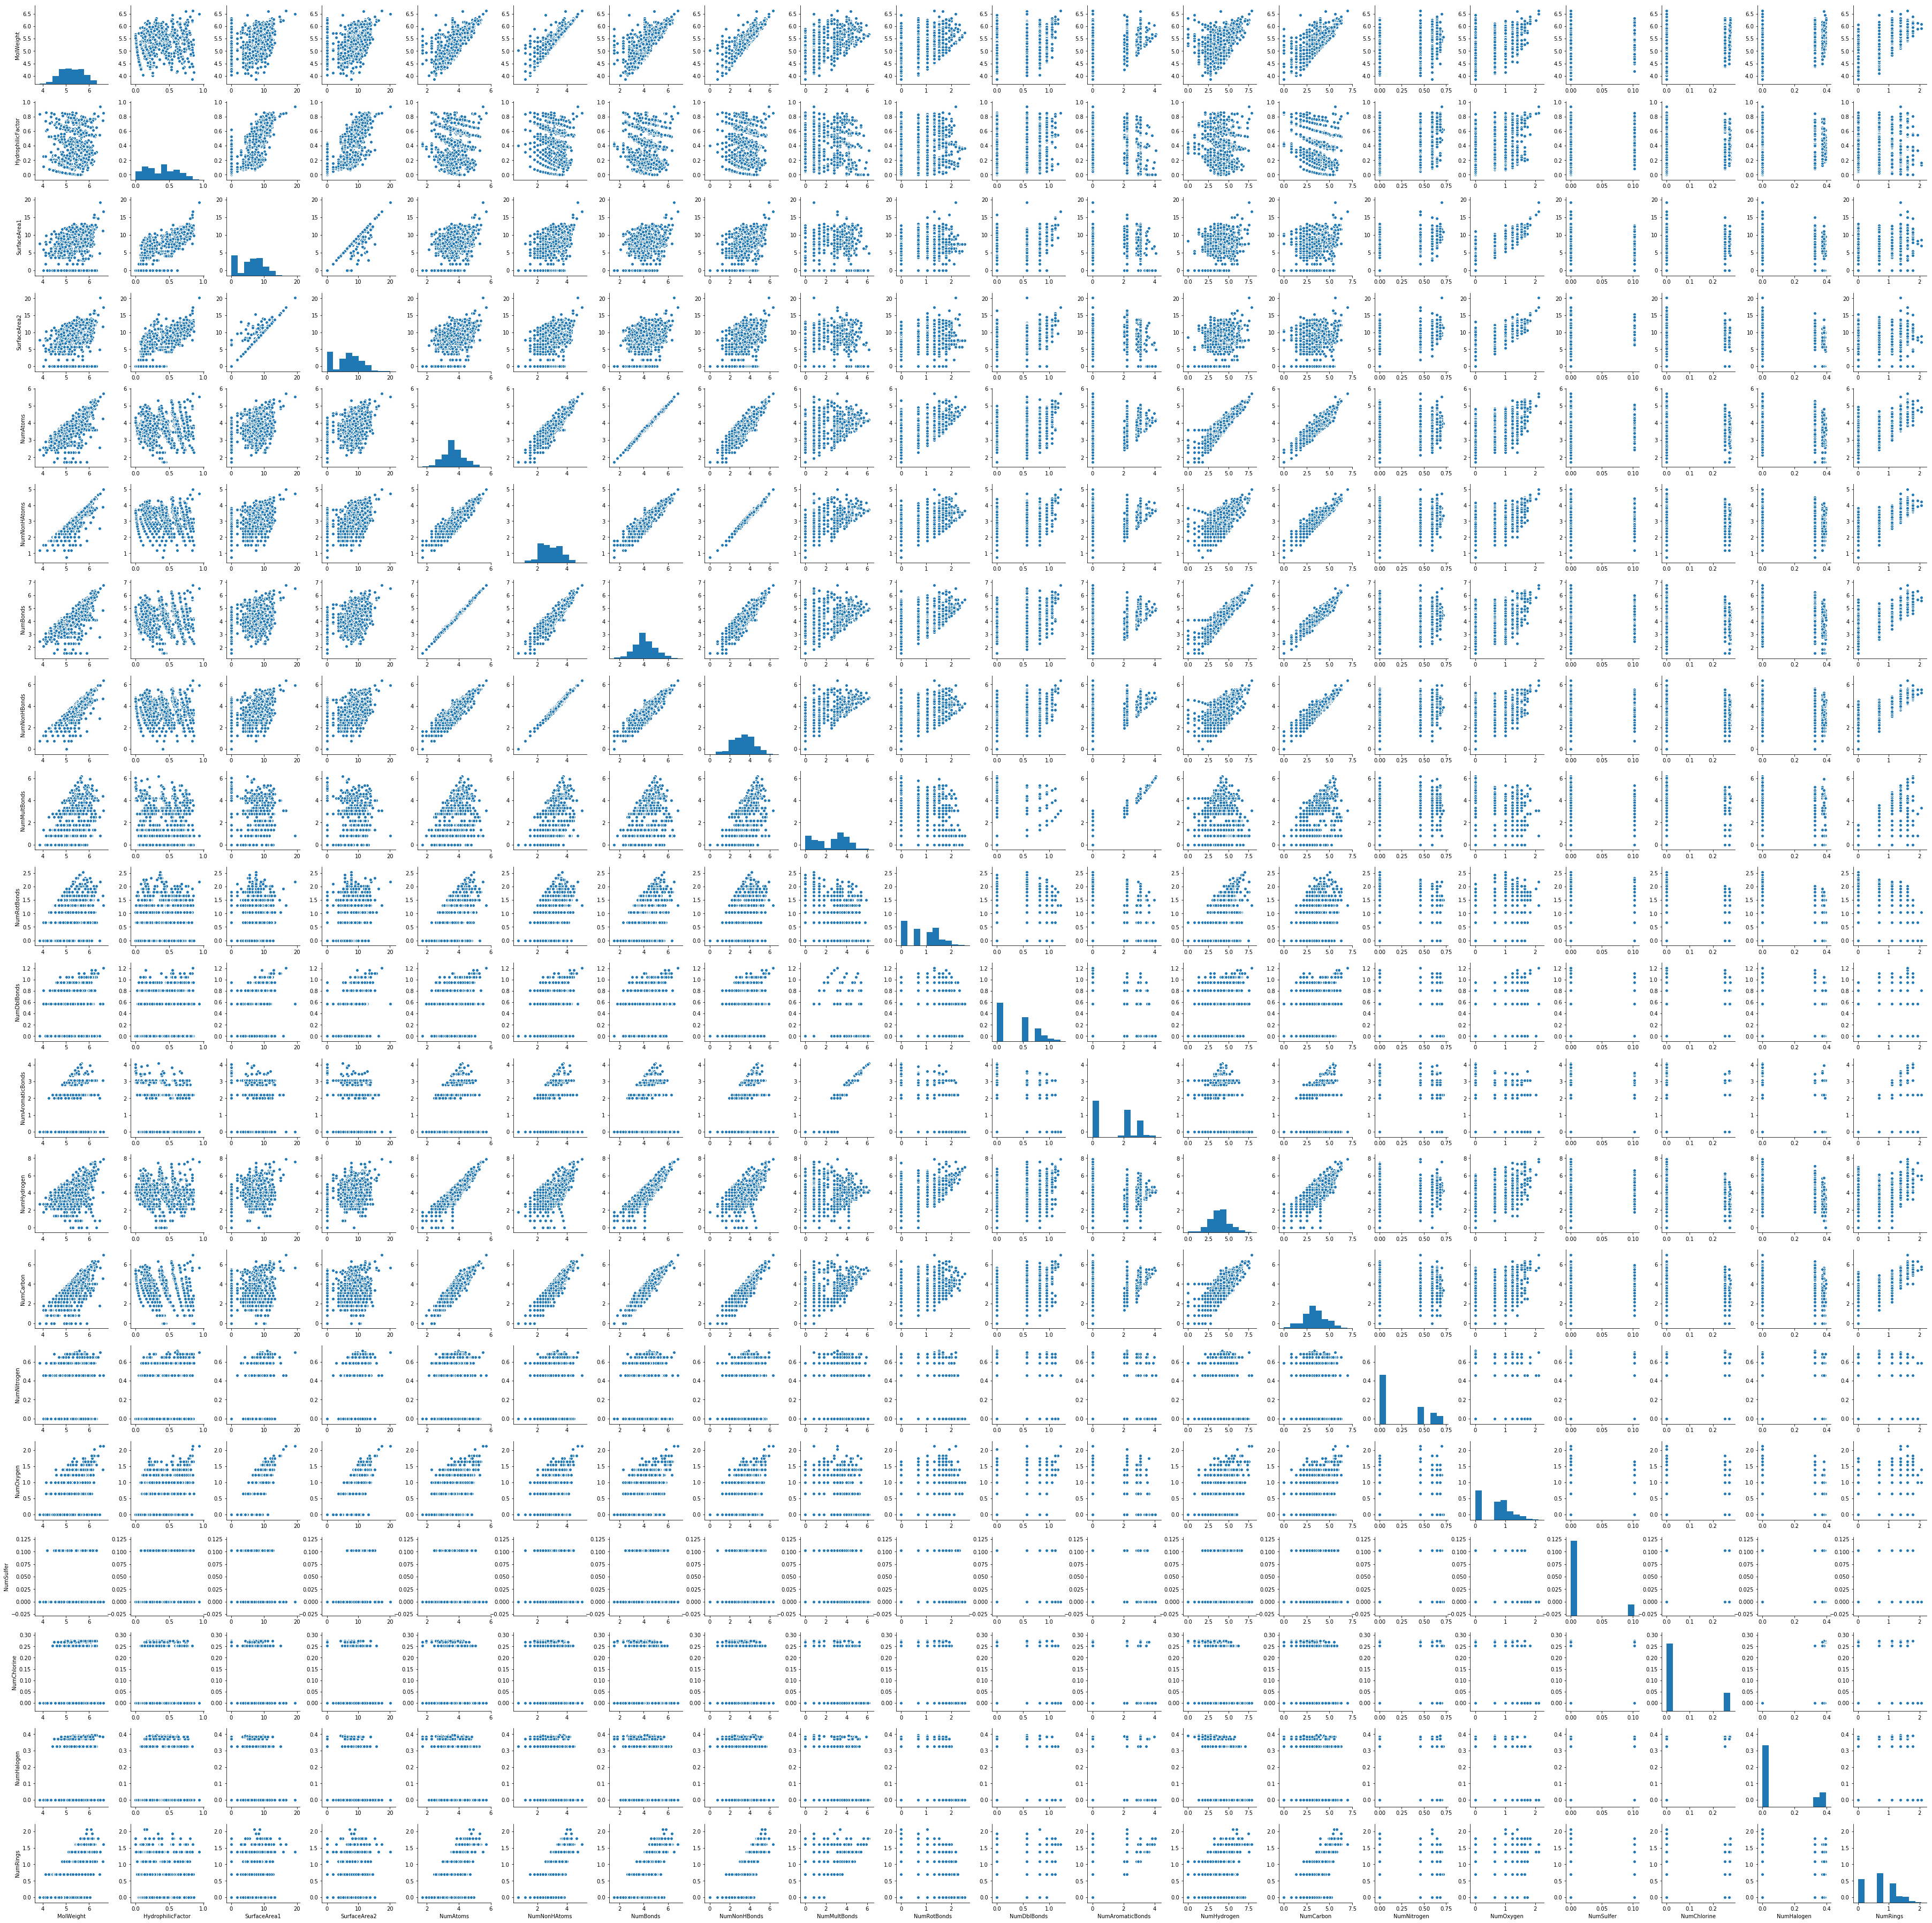

In [176]:
sns.pairplot(data_bx[num_cols+count_cols])

In [187]:
data_bx.columns

Index(['MolWeight', 'HydrophilicFactor', 'SurfaceArea1', 'SurfaceArea2',
       'NumAtoms', 'NumNonHAtoms', 'NumBonds', 'NumNonHBonds', 'NumMultBonds',
       'NumRotBonds',
       ...
       'FP199', 'FP200', 'FP201', 'FP202', 'FP203', 'FP204', 'FP205', 'FP206',
       'FP207', 'FP208'],
      dtype='object', length=228)

In [188]:
X1 = data_bx[['NumNonHAtoms']]
X2 = data_bx[['NumNonHBonds']]
X3 = np.c_[X1, X2]

In [189]:
X1.shape, X2.shape, X3.shape

((951, 1), (951, 1), (951, 2))

In [203]:
sc = StandardScaler()
lr1 = LinearRegression().fit(sc.fit_transform(X1), y_train)
lr2 = LinearRegression().fit(sc.fit_transform(X2), y_train)
lr3 = LinearRegression().fit(sc.fit_transform(X3), y_train)

In [199]:
scores1 = cross_val_score(make_pipeline(StandardScaler(), LinearRegression()), X1, y_train, cv=k10, scoring='r2')
scores1.mean(), scores1.std()

(0.334877576234615, 0.055674079907841088)

In [200]:
scores2 = cross_val_score(make_pipeline(StandardScaler(), LinearRegression()),
                          X2, y_train, cv=k10, scoring='r2')
scores2.mean(), scores2.std()

(0.33690394039122867, 0.057938434117778381)

In [201]:
scores3 = cross_val_score(make_pipeline(StandardScaler(), LinearRegression()),
                          X3, y_train, cv=k10, scoring='r2')
scores3.mean(), scores3.std()

(0.33598525265978091, 0.057290071684008743)

In [204]:
lr1.coef_

array([-1.19088938])

In [205]:
lr2.coef_

array([-1.19477342])

In [206]:
lr3.coef_

array([-0.23235697, -0.96365055])

In [29]:
high_corr = dict()
corr = X_train.corr()
for i, c1 in enumerate(corr.columns):
    for c2 in corr.columns[i+1:]:
        if (c2 not in high_corr) & (corr.loc[c1, c2] >= .9):
            high_corr[c2] = c1
len(high_corr)

35

In [30]:
to_romove_high_corr = list(high_corr.keys())

In [31]:
data_bx_2 = data_bx.drop(to_romove_high_corr, axis=1)

In [32]:
data_bx_2.shape

(951, 193)

In [33]:
lr = LinearRegression().fit(data_bx_2.values, y_train)

In [34]:
scores = cross_val_score(LinearRegression(), data_bx_2.values, y_train, cv=k10, scoring='r2')
scores.mean(), scores.std()

(0.87241879500564556, 0.026199510691771438)

In [35]:
scores = cross_val_score(LinearRegression(), data_bx_2.values, y_train, cv=k10, scoring='neg_mean_squared_error')
rmse = np.sqrt(-scores)
rmse.mean(), rmse.std()

(0.71940644190981295, 0.070392980721042858)

In [36]:
test_bx = bx_transform.transform(X_test)
test_bx = test_bx.drop(to_romove_high_corr, axis=1)

In [37]:
y_pred = lr.predict(test_bx.values)

In [38]:
r2_score(y_test, y_pred)

0.87276126238999518

In [39]:
np.sqrt(mean_squared_error(y_test, y_pred))

0.74022818135340829

Text(0.5,1,'residual plot')

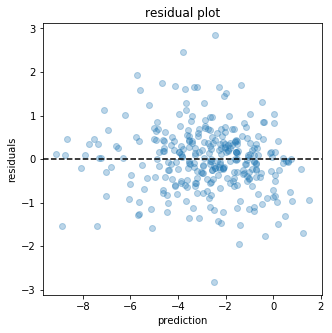

In [40]:
residual = y_test - y_pred
plt.figure(figsize=(5, 5))
plt.plot(y_pred, residual, 'o', alpha=.3)
plt.axhline(y=0, linestyle='--', color='k')
plt.ylabel('residuals')
plt.xlabel('prediction')
plt.title('residual plot')

Text(0,0.5,'true')

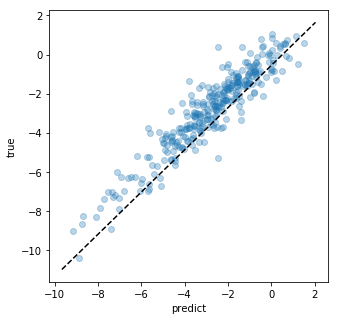

In [41]:
plt.figure(figsize=(5, 5))
plt.plot(y_pred, y_test, 'o', alpha=.3)
xmin, xmax, ymin, ymax = plt.axis()
plt.plot([xmin, xmax], [ymin, ymax], 'k--')
plt.xlabel('predict')
plt.ylabel('true')

### Partial Least Squares (PLS)

In [43]:
data_bx_2.shape, data_bx.shape

((951, 193), (951, 228))

In [74]:
sc = StandardScaler()
pca = PCA(n_components=2)
data_bx_pca = pca.fit_transform(sc.fit_transform(data_bx))

Text(0,0.5,'Y')

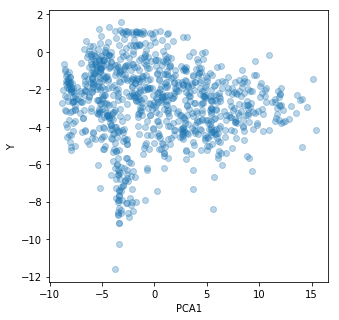

In [75]:
plt.figure(figsize=(5, 5))
plt.plot(data_bx_pca[:, 0], y_train, 'o', alpha=.3)
plt.xlabel('PCA1')
plt.ylabel('Y')

In [76]:
# PCA direction contains no predictive information for the response
lr.fit(data_bx_pca, y_train)
lr.score(data_bx_pca, y_train)

0.07130332739910461

In [64]:
pls = PLSRegression(n_components=2)
pls.fit(data_bx, y_train)

PLSRegression(copy=True, max_iter=500, n_components=2, scale=True, tol=1e-06)

In [68]:
data_bx_pls, y_pls = pls.transform(data_bx, y_train)

Text(0,0.5,'Y')

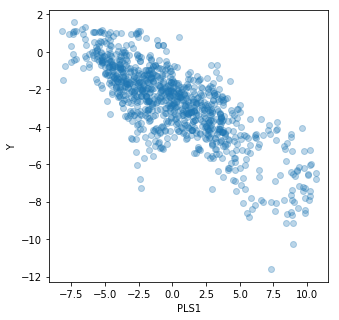

In [71]:
plt.figure(figsize=(5, 5))
plt.plot(data_bx_pls[:, 0], y_train, 'o', alpha=.3)
plt.xlabel('PLS1')
plt.ylabel('Y')

In [73]:
# PLS direction contain highly predictive information for the response
pls.score(data_bx, y_train)

0.74353600733895875

In [118]:
pca_r2 = []
pls_r2 = []
pca_rmse = []
pls_rmse = []

cv = KFold(n_splits=10, shuffle=True, random_state=123)
for n in range(1, 40):
    pca_lr = make_pipeline(StandardScaler(), PCA(n_components=n), LinearRegression())
    pls = make_pipeline(StandardScaler(), PLSRegression(n_components=n, scale=False))
    
    pca_r2_scores = cross_val_score(pca_lr, data_bx, y_train, cv=cv, scoring='r2')
    pls_r2_scores = cross_val_score(pls, data_bx, y_train, cv=cv, scoring='r2')
    pca_nmse_scores = cross_val_score(pca_lr, data_bx, y_train, cv=cv, scoring='neg_mean_squared_error')
    pls_nmse_scores = cross_val_score(pls, data_bx, y_train, cv=cv, scoring='neg_mean_squared_error')
    
    pca_r2.append(pca_r2_scores.mean())
    pls_r2.append(pls_r2_scores.mean())
    
    pca_rmse.append(np.sqrt(-pca_nmse_scores).mean())
    pls_rmse.append(np.sqrt(-pls_nmse_scores).mean())

Text(0,0.5,'r2')

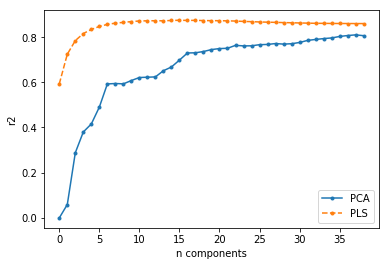

In [119]:
plt.plot(pca_r2, '.-', label='PCA')
plt.plot(pls_r2, '.--', label='PLS')
plt.legend()
plt.xlabel('n components')
plt.ylabel('r2')

Text(0,0.5,'rmse')

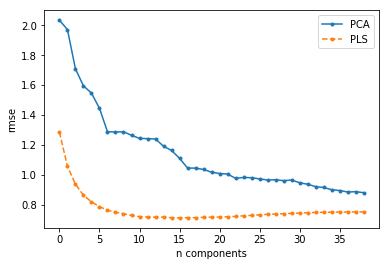

In [120]:
plt.plot(pca_rmse, '.-', label='PCA')
plt.plot(pls_rmse, '.--', label='PLS')
plt.legend()
plt.xlabel('n components')
plt.ylabel('rmse')

In [121]:
np.max(pca_r2), np.max(pls_r2)

(0.81051156946890823, 0.87535950460064971)

In [122]:
np.min(pca_rmse), np.min(pls_rmse)

(0.87909895872007449, 0.71013957635701608)

In [123]:
X_tr, X_val, y_tr, y_val = train_test_split(data_bx, y_train, test_size=.2, random_state=123)

pca_lr = make_pipeline(StandardScaler(), PCA(n_components=.95), LinearRegression())
pls = PLSRegression(n_components=10, scale=True)
    
pca_lr.fit(X_tr, y_tr)
pls.fit(X_tr, y_tr)

PLSRegression(copy=True, max_iter=500, n_components=10, scale=True, tol=1e-06)

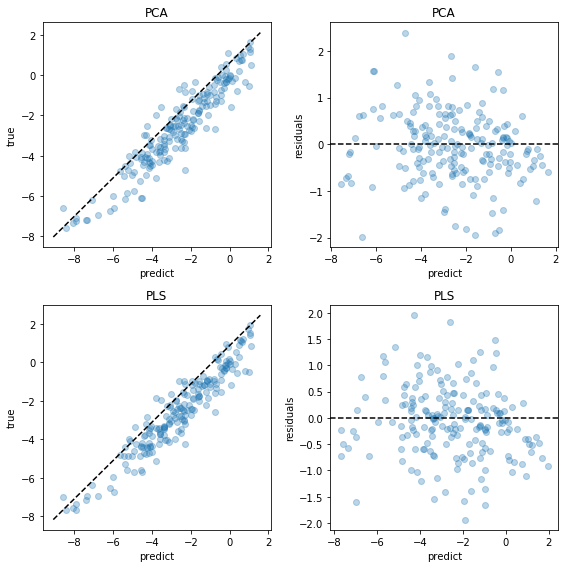

In [110]:
pca_pred = pca_lr.predict(X_val)
pls_pred = pls.predict(X_val).ravel()

pca_residuals = y_val - pca_pred
pls_residuals = y_val - pls_pred

fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(8, 8))

for (ax0, ax1), (R, L, name) in zip(ax, 
                             [(pca_residuals, pca_pred, 'PCA'), (pls_residuals, pls_pred, 'PLS')]):
    ax0.plot(y_val, L, 'o', alpha=.3)
    ax0.plot(ax0.get_xlim(), ax0.get_ylim(), linestyle='--', color='k')
    ax0.set_title(name)
    ax0.set(xlabel='predict', ylabel='true')
    
    ax1.plot(L, R, 'o', alpha=.3)
    ax1.axhline(y=0, linestyle='--', color='k')
    ax1.set(title=name, xlabel='predict', ylabel='residuals')
fig.tight_layout()

In [111]:
xt, yt = pls.transform(X_tr, y_tr)

array([[ 1.        , -0.78054911],
       [-0.78054911,  1.        ]])

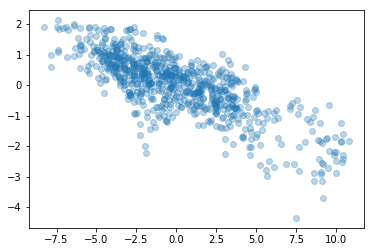

In [117]:
plt.plot(xt[:, 0], yt, 'o', alpha=.3)
np.corrcoef(xt[:, 0], yt)

In [136]:
pls.x_scores_.shape

(760, 10)

In [137]:
pls.x_loadings_.shape

(228, 10)

In [ ]:
pls.x_weights_.shape

In [425]:
pls_rdm = RandomizedSearchCV(make_pipeline(StandardScaler(), PLSRegression()), 
                             {'plsregression__n_components': np.arange(2, 50)}, n_iter=35,
                            cv=k10, scoring='neg_mean_squared_error', n_jobs=-1)
pls_rdm.fit(data_bx, y_train)

RandomizedSearchCV(cv=KFold(n_splits=10, random_state=123, shuffle=True),
          error_score='raise',
          estimator=Pipeline(memory=None,
     steps=[('standardscaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('plsregression', PLSRegression(copy=True, max_iter=500, n_components=2, scale=True, tol=1e-06))]),
          fit_params=None, iid=True, n_iter=35, n_jobs=-1,
          param_distributions={'plsregression__n_components': array([ 2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18,
       19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35,
       36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49])},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score='warn', scoring='neg_mean_squared_error',
          verbose=0)

In [426]:
pls_rdm.best_params_, np.sqrt(-pls_rdm.best_score_)

({'plsregression__n_components': 18}, 0.71352986493653625)

In [429]:
pls_pred = pls_rdm.predict(X_test_bx).ravel()
pls_pred.shape

(316,)

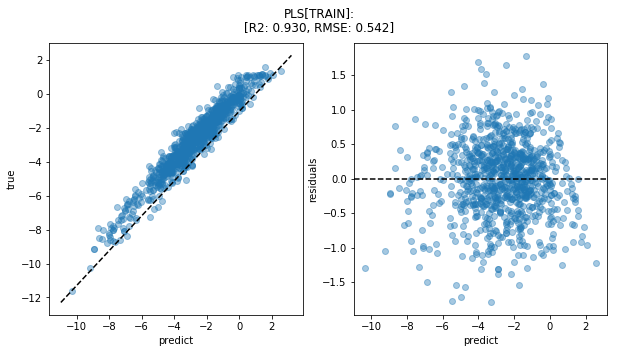

In [431]:
plot_explain(y_train, pls_rdm.predict(data_bx).ravel(), "PLS[Train]")

### Penalized Models

(0, 0.01)

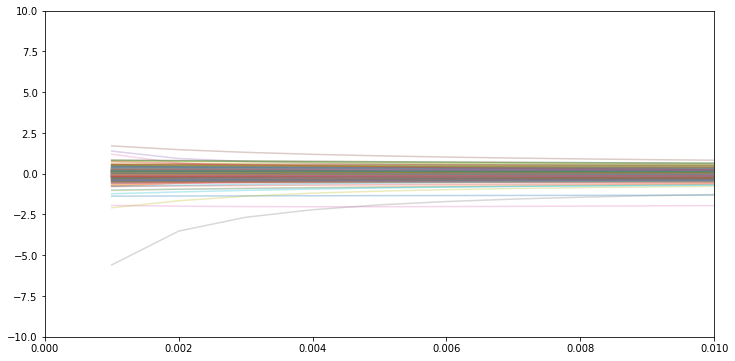

In [233]:
fig, ax = plt.subplots(figsize=(12, 6))
idx = None
lams = np.linspace(.001, .1, 100)
coefs = []
for lam in lams:
    ridge = Ridge(alpha=lam, normalize=True).fit(data_bx, y_train)
    coefs.append(ridge.coef_)
coefs = np.array(coefs)
ax.plot(lams, coefs, alpha=.3)
plt.legend(title='lambda')
ax.set_ylim(-10, 10)
ax.set_xlim(0, .01)

In [220]:
ridge_grid = GridSearchCV(Ridge(normalize=True), {'alpha': np.linspace(0.01, .1, 30)}, 
                          cv=k10, scoring='neg_mean_squared_error', n_jobs=-1, return_train_score=False)

In [221]:
ridge_grid.fit(data_bx, y_train)

GridSearchCV(cv=KFold(n_splits=10, random_state=123, shuffle=True),
       error_score='raise',
       estimator=Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=True, random_state=None, solver='auto', tol=0.001),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'alpha': array([ 0.01   ,  0.0131 ,  0.01621,  0.01931,  0.02241,  0.02552,
        0.02862,  0.03172,  0.03483,  0.03793,  0.04103,  0.04414,
        0.04724,  0.05034,  0.05345,  0.05655,  0.05966,  0.06276,
        0.06586,  0.06897,  0.07207,  0.07517,  0.07828,  0.08138,
        0.08448,  0.08759,  0.09069,  0.09379,  0.0969 ,  0.1    ])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
       scoring='neg_mean_squared_error', verbose=0)

In [222]:
pd.DataFrame(ridge_grid.cv_results_)

mean_fit_time  mean_score_time  mean_test_score param_alpha  \
0        0.031700         0.003058        -0.502371        0.01   
1        0.027473         0.002219        -0.495672   0.0131034   
2        0.034924         0.000712        -0.490931   0.0162069   
3        0.035580         0.002164        -0.487492   0.0193103   
4        0.024244         0.002557        -0.484968   0.0224138   
5        0.023243         0.003247        -0.483117   0.0255172   
6        0.029427         0.000732        -0.481775   0.0286207   
7        0.022603         0.000932        -0.480828   0.0317241   
8        0.026220         0.001908        -0.480195   0.0348276   
9        0.029958         0.001715        -0.479815    0.037931   
10       0.022793         0.000671        -0.479642   0.0410345   
11       0.024745         0.000804        -0.479640   0.0441379   
12       0.032809         0.001074        -0.479780   0.0472414   
13       0.014022         0.003499        -0.480039   0.0503448   
14       0.036840         0.001577        -0.480401   0.0534483   
15       0.030504         0.002145        -0.480848   0.0565517   
16       0.016232         0.001187        -0.481370   0.0596552   
17       0.013538         0.000704        -0.481955   0.0627586   
18       0.024018         0.000640        -0.482595   0.0658621   
19       0.024605         0.001639        -0.483283   0.0689655   
20       0.023414         0.001353        -0.484011    0.072069   
21       0.028160         0.001422        -0.484775   0.0751724   
22       0.027848         0.000975        -0.485570   0.0782759   
23       0.020508         0.001717        -0.486392   0.0813793   
24       0.024225         0.000875        -0.487238   0.0844828   
25       0.025605         0.002745        -0.488104   0.0875862   
26       0.027170         0.000623        -0.488988   0.0906897   
27       0.031565         0.001198        -0.489887   0.0937931   
28       0.015936         0.001129        -0.490800   0.0968966   
29       0.022512         0.000991        -0.491724         0.1   

                        params  rank_test_score  split0_test_score  \
0              {'alpha': 0.01}               30          -0.411714   
1   {'alpha': 0.0131034482759}               29          -0.403717   
2   {'alpha': 0.0162068965517}               27          -0.397436   
3   {'alpha': 0.0193103448276}               22          -0.392340   
4   {'alpha': 0.0224137931034}               18          -0.388120   
5   {'alpha': 0.0255172413793}               14          -0.384576   
6   {'alpha': 0.0286206896552}               11          -0.381572   
7    {'alpha': 0.031724137931}                8          -0.379011   
8   {'alpha': 0.0348275862069}                6          -0.376818   
9   {'alpha': 0.0379310344828}                4          -0.374938   
10  {'alpha': 0.0410344827586}                2          -0.373324   
11  {'alpha': 0.0441379310345}                1          -0.371941   
12  {'alpha': 0.0472413793103}                3          -0.370758   
13  {'alpha': 0.0503448275862}                5          -0.369752   
14  {'alpha': 0.0534482758621}                7          -0.368901   
15  {'alpha': 0.0565517241379}                9          -0.368188   
16  {'alpha': 0.0596551724138}               10          -0.367597   
17  {'alpha': 0.0627586206897}               12          -0.367116   
18  {'alpha': 0.0658620689655}               13          -0.366733   
19  {'alpha': 0.0689655172414}               15          -0.366438   
20  {'alpha': 0.0720689655172}               16          -0.366223   
21  {'alpha': 0.0751724137931}               17          -0.366080   
22   {'alpha': 0.078275862069}               19          -0.366003   
23  {'alpha': 0.0813793103448}               20          -0.365984   
24  {'alpha': 0.0844827586207}               21          -0.366020   
25  {'alpha': 0.0875862068966}               23          -0.366105   
26  {'alpha': 0.0906896551724}      

In [223]:
scores = np.sqrt(-ridge_grid.cv_results_['mean_test_score'])
alphas = np.array(ridge_grid.cv_results_['param_alpha'], dtype=float)

Text(0,0.5,'RMSE [CV]')

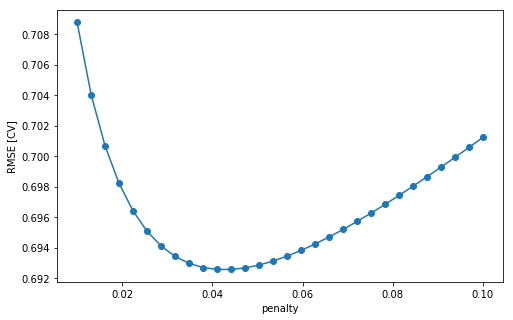

In [224]:
plt.figure(figsize=(8, 5))
plt.plot(alphas, scores, 'o-')
plt.xlabel('penalty')
plt.ylabel('RMSE [CV]')

In [448]:
ridge_rdm = RandomizedSearchCV(make_pipeline(StandardScaler(), Ridge(normalize=True)),
                               {'ridge__alpha': expon(loc=0, scale=.2)}, return_train_score=True,
                               n_iter=100, cv=k10, scoring='neg_mean_squared_error', n_jobs=-1)
ridge_rdm.fit(data_bx, y_train)

RandomizedSearchCV(cv=KFold(n_splits=10, random_state=123, shuffle=True),
          error_score='raise',
          estimator=Pipeline(memory=None,
     steps=[('standardscaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('ridge', Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=True, random_state=None, solver='auto', tol=0.001))]),
          fit_params=None, iid=True, n_iter=100, n_jobs=-1,
          param_distributions={'ridge__alpha': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7fe3e93f8cc0>},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score=True, scoring='neg_mean_squared_error',
          verbose=0)

In [449]:
ridge_rdm.best_params_, np.sqrt(-ridge_rdm.best_score_)

({'ridge__alpha': 0.03952279510333475}, 0.69260600727845645)

In [270]:
pd.DataFrame(ridge_rdm.cv_results_)

mean_fit_time  mean_score_time  mean_test_score  mean_train_score  \
0        0.039016         0.001136        -0.496051         -0.348648   
1        0.024115         0.001077        -0.570589         -0.460513   
2        0.027271         0.001057        -0.598398         -0.495860   
3        0.032163         0.003010        -0.480675         -0.286181   
4        0.030096         0.002715        -0.535793         -0.413073   
5        0.033425         0.001438        -0.597584         -0.494849   
6        0.024119         0.000916        -0.481631         -0.282725   
7        0.023691         0.000834        -0.524865         -0.249879   
8        0.024603         0.000677        -0.488592         -0.332648   
9        0.024308         0.002207        -0.479640         -0.297486   
10       0.026346         0.001032        -0.504848         -0.364842   
11       0.024529         0.000677        -0.497260         -0.351001   
12       0.026129         0.001501        -0.516383         -0.383915   
13       0.038473         0.001189        -0.622736         -0.525580   
14       0.021129         0.003276        -0.481558         -0.311555   
15       0.032768         0.001153        -0.479969         -0.290243   
16       0.026504         0.000876        -0.507365         -0.369166   
17       0.018257         0.000723        -0.511816         -0.376574   
18       0.025533         0.002111        -0.484211         -0.276759   
19       0.024296         0.003106        -0.501974         -0.359757   
20       0.025484         0.000763        -0.492081         -0.340519   
21       0.029420         0.004255        -0.489400         -0.334551   
22       0.025299         0.000823        -0.491316         -0.267522   
23       0.022034         0.000603        -0.500370         -0.356843   
24       0.024885         0.001247        -0.561744         -0.448863   
25       0.022604         0.000669        -0.508896         -0.371746   
26       0.020222         0.000620        -0.486410         -0.327183   
27       0.023701         0.000622        -0.526715         -0.399777   
28       0.027979         0.001216        -0.495894         -0.348339   
29       0.032521         0.000961        -0.494354         -0.345257   
..            ...              ...              ...               ...   
70       0.028275         0.001013        -0.707439         -0.623561   
71       0.015721         0.001697        -0.480608         -0.306868   
72       0.019084         0.002313        -0.479820         -0.300762   
73       0.041942         0.001108        -0.482019         -0.313456   
74       0.022248         0.000643        -0.551489         -0.435042   
75       0.023163         0.000828        -0.579392         -0.471895   
76       0.025804         0.000952        -0.577775         -0.469818   
77       0.026884         0.001065        -0.530099         -0.404793   
78       0.020483         0.000675        -0.616851         -0.518479   
79       0.029445         0.001172        -0.615603         -0.516966   
80       0.028939         0.001104        -0.522870         -0.393978   
81       0.021094         0.000679        -0.509983         -0.373557   
82       0.021373         0.001421        -0.531276         -0.406521   
83       0.023316         0.000781        -0.479624         -0.296574   
84       0.022267         0.000637        -0.604859         -0.503845   
85       0.025207         0.001350        -0.624976         -0.528269   
86       0.021313         0.000921        -0.481408         -0.310896   
87       0.018629         0.001883        -0.506871         -0.368325   
88       0.027162         0.001537        -0.494059         -0.344655   
89       0.018908         0.001460        -0.523185         -0.394458   
90       0.042878         0.000852        -0.479761         -0.299992   
91       0.020141         0.000580        -0.549727         -0.432628   
92       0.022358         0.000637        -0.486606         -0

(0.65, 0.8)

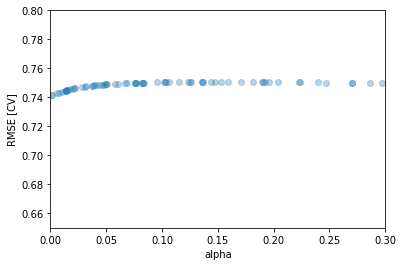

In [445]:
alphas = np.array(ridge_rdm.cv_results_['param_ridge__alpha'])
idx = np.argsort(alphas)
scores = ridge_rdm.cv_results_['mean_test_score']

alphas = alphas[idx]
scores = np.sqrt(-scores[idx])

plt.plot(alphas, scores, 'o', alpha=.3)
plt.ylabel('RMSE [CV]')
plt.xlabel('alpha')
plt.xlim(0, 0.3)
plt.ylim(0.65, 0.8)

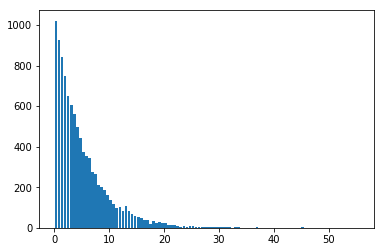

In [273]:
a = expon(loc=0, scale=5)
_ = plt.hist(a.rvs(size=10000), bins=100, rwidth=.9)

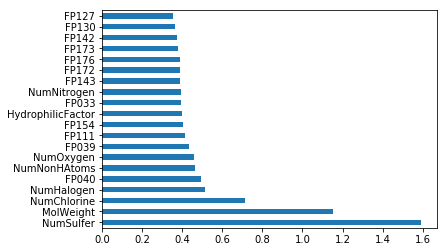

In [279]:
pd.Series(ridge_rdm.best_estimator_.coef_, index=data_bx.columns).abs().sort_values(ascending=False)[:20].plot.barh()

In [453]:
lasso_rdm = RandomizedSearchCV(make_pipeline(StandardScaler(), Lasso(normalize=False, max_iter=5000)), 
                               {'lasso__alpha': expon(loc=0, scale=0.15)}, 
                               return_train_score=True, n_iter=100, n_jobs=-1, cv=k10, scoring='neg_mean_squared_error')
lasso_rdm.fit(data_bx, y_train)

RandomizedSearchCV(cv=KFold(n_splits=10, random_state=123, shuffle=True),
          error_score='raise',
          estimator=Pipeline(memory=None,
     steps=[('standardscaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('lasso', Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=5000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False))]),
          fit_params=None, iid=True, n_iter=100, n_jobs=-1,
          param_distributions={'lasso__alpha': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7fe3e8c5e2e8>},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score=True, scoring='neg_mean_squared_error',
          verbose=0)

In [454]:
lasso_rdm.best_params_, np.sqrt(-lasso_rdm.best_score_)

({'lasso__alpha': 0.0041543350750508174}, 0.69059288656849505)

(-0.01, 0.05)

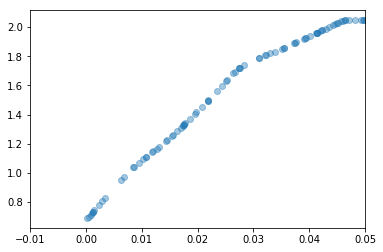

In [326]:
alphas = np.array(lasso_rdm.cv_results_['param_alpha'], dtype=float)
idx = np.argsort(alphas)

scores = lasso_rdm.cv_results_['mean_test_score'][idx]

plt.plot(alphas[idx], np.sqrt(-scores), 'o', alpha=.4)
plt.xlim(-0.01, .05)

In [303]:
np.argmax(data_bx.columns == 'NumNonHAtoms'), np.argmax(data_bx.columns == 'NumNonHBonds')

(5, 7)

In [304]:
lasso_rdm.best_estimator_.coef_[5], lasso_rdm.best_estimator_.coef_[7]

(-1.4335322628961658, -0.0)

In [305]:
ridge_rdm.best_estimator_.coef_[5], ridge_rdm.best_estimator_.coef_[7]

(-0.46175172617867866, -0.27581833129443195)

In [361]:
elas_rdm = RandomizedSearchCV(make_pipeline(StandardScaler(), ElasticNet(normalize=False, max_iter=5000)),
                              {'elasticnet__alpha':expon(0, 0.3), 'elasticnet__l1_ratio':uniform(0, 1)}, 
                                cv=k10, scoring='neg_mean_squared_error', n_iter=100, n_jobs=-1)
elas_rdm.fit(data_bx, y_train)

RandomizedSearchCV(cv=KFold(n_splits=10, random_state=123, shuffle=True),
          error_score='raise',
          estimator=Pipeline(memory=None,
     steps=[('standardscaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('elasticnet', ElasticNet(alpha=1.0, copy_X=True, fit_intercept=True, l1_ratio=0.5,
      max_iter=5000, normalize=False, positive=False, precompute=False,
      random_state=None, selection='cyclic', tol=0.0001, warm_start=False))]),
          fit_params=None, iid=True, n_iter=100, n_jobs=-1,
          param_distributions={'elasticnet__l1_ratio': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7fe3e8be95c0>, 'elasticnet__alpha': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7fe3e8be9668>},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score='warn', scoring='neg_mean_squared_error',
          verbose=0)

In [362]:
elas_rdm.best_params_, np.sqrt(-elas_rdm.best_score_)

({'elasticnet__alpha': 0.015493160017414539,
  'elasticnet__l1_ratio': 0.41008096895893098},
 0.68938411295891966)

In [332]:
(np.abs(elas_rdm.best_estimator_.coef_) > 0).sum()

157

In [333]:
data_bx.shape

(951, 228)

In [334]:
X_test_bx = bx_transform.transform(X_test)

In [371]:
ridge_pred = ridge_rdm.predict(X_test_bx)
lasso_pred = lasso_rdm.predict(X_test_bx)
elas_pred = elas_rdm.predict(X_test_bx)

In [372]:
r2_score(y_test, ridge_pred), r2_score(y_test, lasso_pred), r2_score(y_test, elas_pred)

(0.88071308863784381, 0.88537060862362016, 0.88502975148929075)

In [373]:
np.sqrt(mean_squared_error(y_test, ridge_pred)), np.sqrt(mean_squared_error(y_test, lasso_pred)), np.sqrt(mean_squared_error(y_test, elas_pred))

(0.71672464175562922, 0.70259318452509778, 0.70363700989567646)

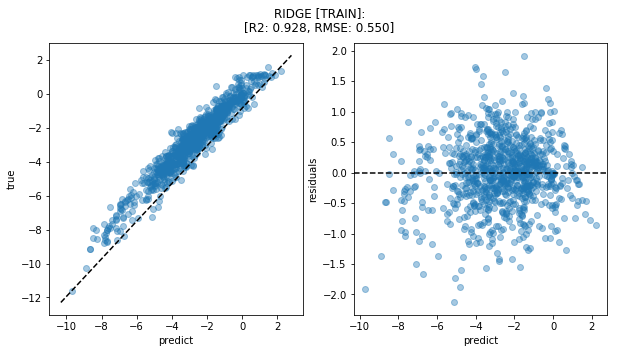

In [434]:
plot_explain(y_train, ridge_rdm.predict(data_bx), 'Ridge [train]')

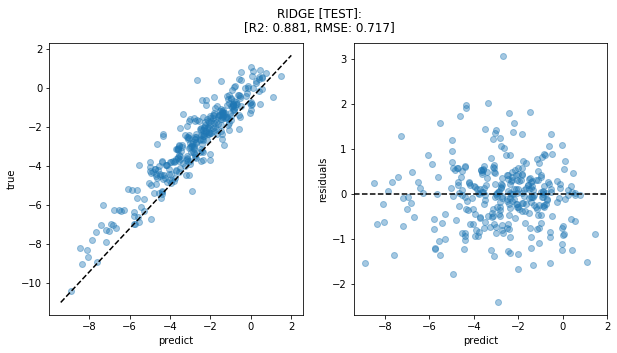

In [435]:
plot_explain(y_test, ridge_pred, 'Ridge [Test]')

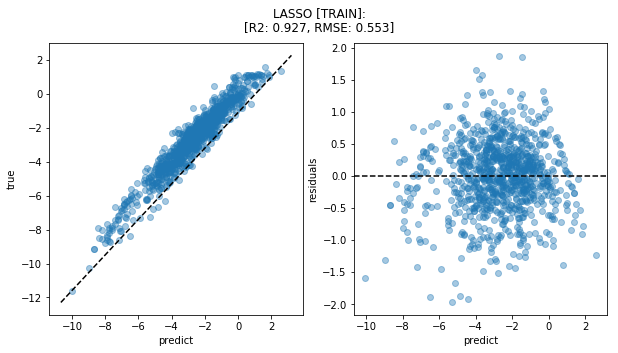

In [436]:
plot_explain(y_train, lasso_rdm.predict(data_bx), 'lasso [train]')

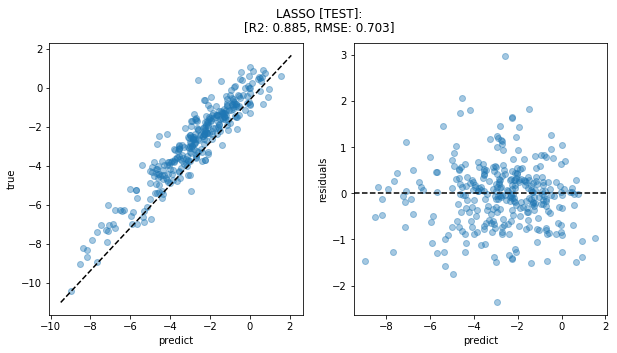

In [437]:
plot_explain(y_test, lasso_pred, 'Lasso [test]')

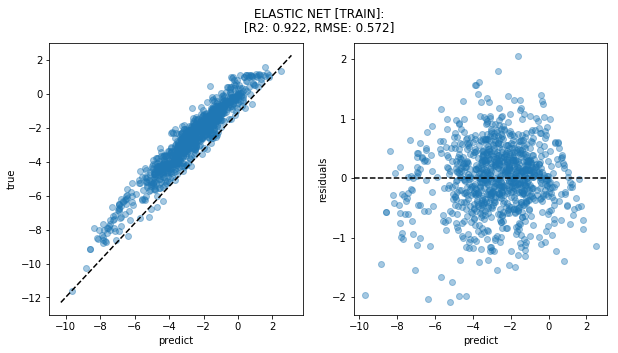

In [432]:
plot_explain(y_train, elas_rdm.predict(data_bx), 'Elastic Net [Train]')

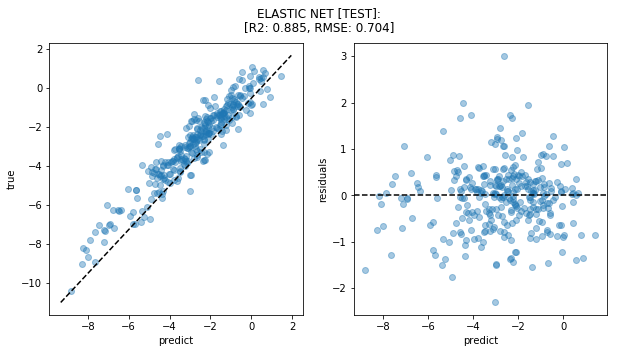

In [433]:
plot_explain(y_test, elas_pred, 'Elastic Net [Test]')

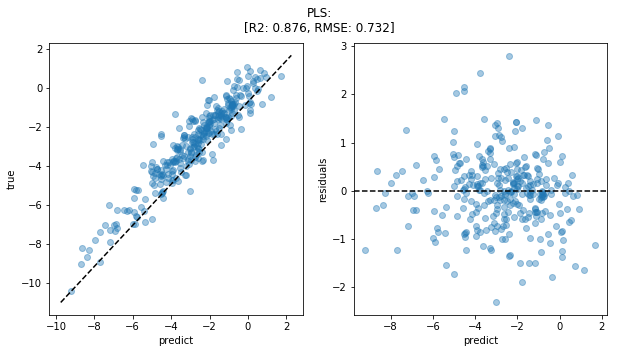

In [430]:
plot_explain(y_test, pls_pred, 'PLS')